In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
import time
import h5py
sns.set_style("whitegrid")
np.random.seed(1)

In [2]:
class LogNetwork():
    
    def __init__(self, X, y, epochs=1000, learnig_rate=0.01, layer_dims=[20, 7, 5]):
        
        self.X = X # n x m
        self.y = y # 1 x m
        
        self.nx = self.X.shape[0] # n
        self.m = self.X.shape[1] # m
        
        self.parameters = {}
        self.num_layers = len(layer_dims) + 1
        
        self.epochs = epochs
        self.costs = []
        self.learning_rate = learnig_rate
                
        # First Layer
        self.parameters["W" + str(1)] = np.random.randn(layer_dims[0], self.nx) / np.sqrt(self.nx)
        self.parameters["b" + str(1)] = np.zeros((layer_dims[0], 1))
       
        # Hidden Layers
        for l in range(1, len(layer_dims)):
            self.parameters['W' + str(l + 1)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) / np.sqrt(layer_dims[l - 1])
            self.parameters["b" + str(l + 1)] = np.zeros((layer_dims[l], 1))
        
        # Output Layer
        self.parameters["W" + str(len(layer_dims) + 1)] = np.random.randn(1, layer_dims[-1]) / np.sqrt(layer_dims[-1])
        self.parameters["b" + str(len(layer_dims) + 1)] = np.zeros((1, 1))

    
    @staticmethod
    def sigmoid(Z):
        
        A = ( 1 + np.exp(-Z) ) ** -1
        
        return A
    
    @staticmethod
    def relu(Z):

        A = np.maximum(0, Z)

        assert(A.shape == Z.shape)

        return A
    
    @staticmethod
    def relu_backward(dA, Z):

        dZ = np.array(dA, copy=True)
        
        dZ[Z <= 0] = 0
        
        return dZ

    @staticmethod
    def sigmoid_backward(dA, Z):

        A = 1 / ( 1 + np.exp(-Z) )
        
        dZ = dA * (A * ( 1 - A ))

        return dZ
    
    def forward_pass(self, A0):
        
        A_prev = A0
        Z_cache = {}
        A_cache = {}
        
        for L in range(1, self.num_layers + 1):
            
            if L == self.num_layers:
                
                Z = np.dot(self.parameters[f"W{L}"], A_prev) + self.parameters[f"b{L}"]
                A = self.sigmoid(Z)

                Z_cache[f"Z{L}"] = Z
                A_cache[f"A{L}"] = A
                
            else:
                
                Z = np.dot(self.parameters[f"W{L}"], A_prev) + self.parameters[f"b{L}"]
                A = self.relu(Z)

                Z_cache[f"Z{L}"] = Z
                A_cache[f"A{L}"] = A
                
                A_prev = A

        return Z_cache, A_cache
    
    
    def compute_cost(self, A):

        loss = - ( ( np.dot(self.y, np.log(A.T)) + np.dot((1 - self.y), np.log(1 - A.T)) ) ) / self.m
        
        return loss
    
    def backward_pass(self, Z_cache, A_cache):
        
        # Adjoin X as A0 to A_Cache
        
        A_cache["A0"] = self.X
        grads = {}
        
        Al = A_cache[f"A{self.num_layers}"]
        dAl = - np.divide(self.y, Al) + np.divide(1 - self.y, 1 - Al)
        
        # L, L-1, ...
        for L in reversed(range(1, self.num_layers + 1)):
            
            # Output layer
            if L == self.num_layers:
                
                dZ = self.sigmoid_backward(dAl, Z_cache[f"Z{L}"])
                dW = np.dot(dZ, A_cache[f"A{L-1}"].T) / self.m
                db = np.sum(dZ, axis=1, keepdims=True) / self.m
                dA_prev = np.dot(self.parameters[f"W{L}"].T, dZ)
                grads[f"dW{L}"] = dW
                grads[f"db{L}"] = db


            else:
                
                dZ = self.relu_backward(dA_prev, Z_cache[f"Z{L}"])
                dW = np.dot(dZ, A_cache[f"A{L-1}"].T) / self.m
                db = np.sum(dZ, axis=1, keepdims=True) / self.m
                dA_prev = np.dot(self.parameters[f"W{L}"].T, dZ)
                grads[f"dW{L}"] = dW
                grads[f"db{L}"] = db
                
        return grads
    
    def update_params(self, grads):
        
        for L in range(1, self.num_layers+1):

            self.parameters[f"W{L}"] -= self.learning_rate * grads[f"dW{L}"] 
            
            self.parameters[f"b{L}"] -= self.learning_rate * grads[f"db{L}"] 
        
    def plot(self):
        
        costs = np.array(self.costs)
        _ = plt.plot(costs)
        _ = plt.plot(costs.argmin(), costs.min(), "ro", markerfacecolor="w")
        _ = plt.text(costs.argmin() + 0.05, costs.min() + 0.05, f"{costs.min():.3f}")
        
    
    def launch_network(self, print_cost=False):
        
        
        for e in range(self.epochs):
            
            Z_cache, A_cache = self.forward_pass(self.X)
            
            loss = self.compute_cost(A_cache[f"A{self.num_layers}"])
            if e % 100 == 0:
                self.costs.append(np.squeeze(loss))
            
            grads = self.backward_pass(Z_cache, A_cache)
            
            self.update_params(grads)
            
            if e % 500 == 0 and print_cost:
                print(f"Cost after iteration {e} = {np.round(np.squeeze(loss), 4)}")                
                

In [3]:
def load_data():
    
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig

train_x_orig, train_y_orig = load_data()

In [4]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten / 255

print ("train_x's shape: " + str(train_x.shape))

train_x's shape: (12288, 209)


Cost after iteration 0 = 0.7717
Cost after iteration 500 = 0.5401
Cost after iteration 1000 = 0.3152
Cost after iteration 1500 = 0.1612
Cost after iteration 2000 = 0.1138
Cost after iteration 2500 = 0.0884
Cost after iteration 3000 = 0.0733
Total Time = 45.206


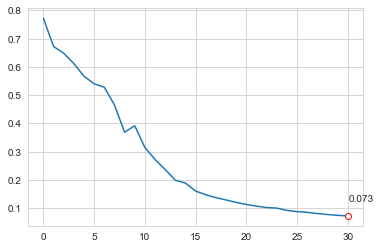

In [5]:
begin = time.time()
Net = LogNetwork(X=train_x, y=train_y_orig, epochs=3001, learnig_rate=0.0075, layer_dims=[20, 7, 5])
_ = Net.launch_network(print_cost=True)
_ = Net.plot()
end = time.time()
print(f"Total Time = {np.round(end - begin, 3)}")